In [1]:
from rl_trading_framework import *
from tqdm.notebook import tqdm
from config import *

In [2]:
# from rl_validation
%store -r selected_pair_names
batch_size_test = len(selected_pair_names)
print(selected_pair_names)

['TSLA-QCOM', 'INTC-PYPL', 'NVDA-CSCO', 'NVDA-PYPL', 'AMZN-IBM', 'TSLA-PYPL', 'AMD-CRM', 'MSFT-QCOM', 'NVDA-TXN', 'MSFT-PYPL']


In [3]:
tickers = set()
for pair in selected_pair_names:
    ticker = pair.split('-')
    tickers.update(ticker)
tickers = list(tickers)
print(tickers)

pair_indices = []
ticker_to_index = {ticker: index for index, ticker in enumerate(tickers)}
for pair in selected_pair_names:
    two_tickers = pair.split('-')
    idx1, idx2 = ticker_to_index[two_tickers[0]], ticker_to_index[two_tickers[1]]
    pair_indices.append((idx1, idx2))
print(pair_indices)

['INTC', 'NVDA', 'CSCO', 'AMD', 'TSLA', 'QCOM', 'PYPL', 'AMZN', 'IBM', 'CRM', 'TXN', 'MSFT']
[(4, 5), (0, 6), (1, 2), (1, 6), (7, 8), (4, 6), (3, 9), (11, 5), (1, 10), (11, 6)]


In [4]:
price_data_all = get_data_torch(tickers, test_start, test_end, multiplier, data_freq, device)

getting data:   0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
# instantiate model
state_encoding_model = StateEncodingModel(device, batch_size_test, input_dim=8, lstm_hidden_dim=lstm_hidden_dim, num_layers=lstm_num_layers).to(device)
trading_policy_model = TradingPolicyModel(lstm_hidden_dim, mlp_hidden_dim, action_dim).to(device)
trading_agent = TradingAgent(state_encoding_model, trading_policy_model)
env = TradingEnvironment(state_encoding_model, reg_rolling_window, batch_size_test, portfolio_settings, action_dim, device, full_sample_test, pair_indices_given=pair_indices)

# load model paras
load_model_paras(state_encoding_model, model_folder_path, encoding_model_file_name)
load_model_paras(trading_policy_model, model_folder_path, policy_model_file_name)
state_encoding_model.reset_state(batch_size_test)

In [6]:
# agent trading
env.update_data(price_data_all)
env.reset()
done = False
trajectory = []
action_history = []
port_value_history = [np.array(env.port_value)]
quantity_history = [[(float(x), float(y)) for x, y in zip(env.x_quantity, env.y_quantity)]]

with tqdm(total=env.period_len-reg_rolling_window, desc='agent trading') as pbar:
    while not done:     # for t in range(reg_rolling_window, env.period_len):
        ob_t = env.update_observation()
        encoded_state = state_encoding_model(ob_t)
        env.norm_port_value = (env.port_value / env.bt_settings['initial_cash']).unsqueeze(1)
        action = trading_agent.choose_action(encoded_state, env.norm_port_value, method_in_test)
        reward, ob_t, done = env.step(action)       # reward not used for now

        action_history.append(np.array(action))
        port_value_history.append(np.array(env.port_value))
        quantity_history.append([(float(x), float(y)) for x, y in zip(env.x_quantity, env.y_quantity)])
        trajectory.append((encoded_state, action, reward))      # trajectory not used for now
        pbar.update(1)

action_history = np.array(action_history)
port_value_history = np.array(port_value_history) / env.bt_settings['initial_cash']
quantity_history = np.array(quantity_history)
pair_names = [f"{tickers[i]}-{tickers[j]}" for i, j in env.pair_indices]

agent trading:   0%|          | 0/230 [00:00<?, ?it/s]

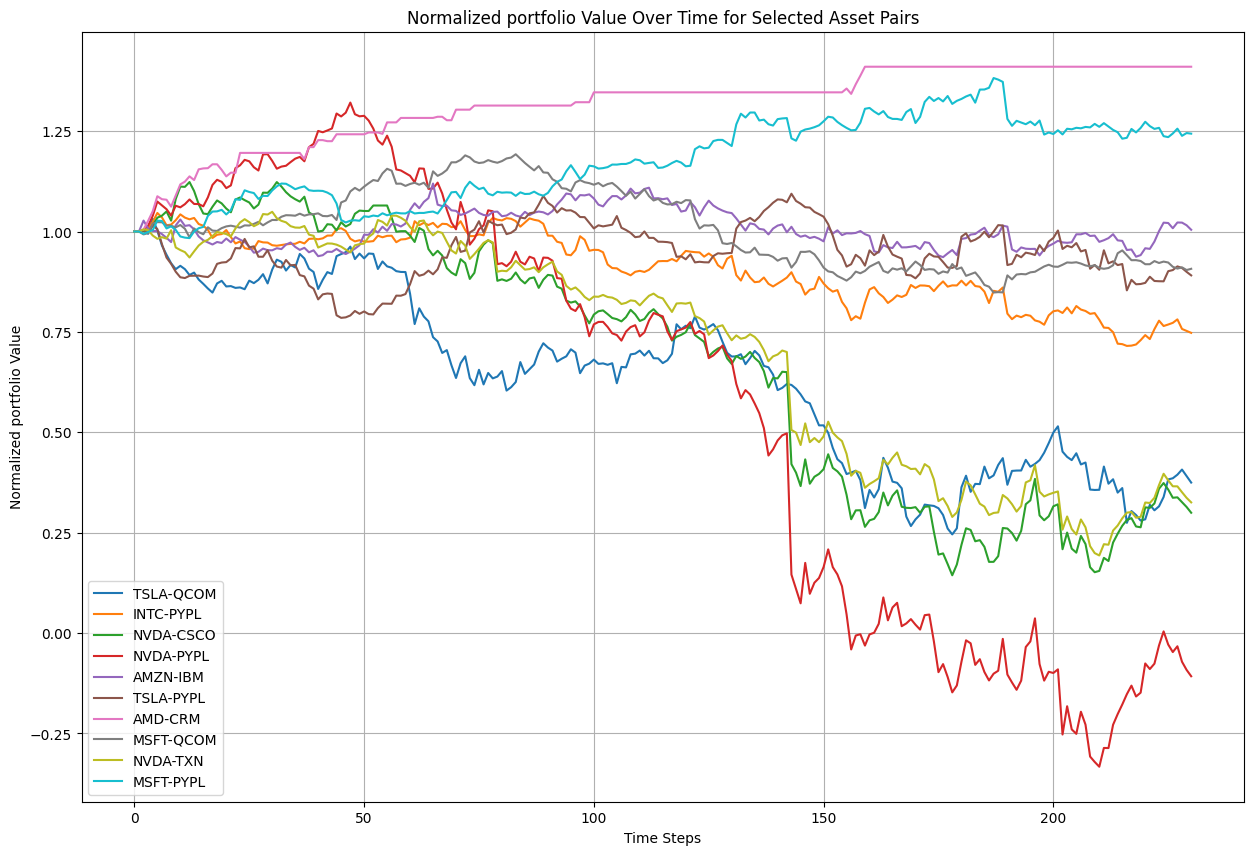

In [7]:
num_quantiles = 1
top_n_pairs_each_quantile = len(selected_pair_names)     # plot all
selected_pair_names = plot_and_return_top_pairs(num_quantiles, top_n_pairs_each_quantile, port_value_history, pair_names)

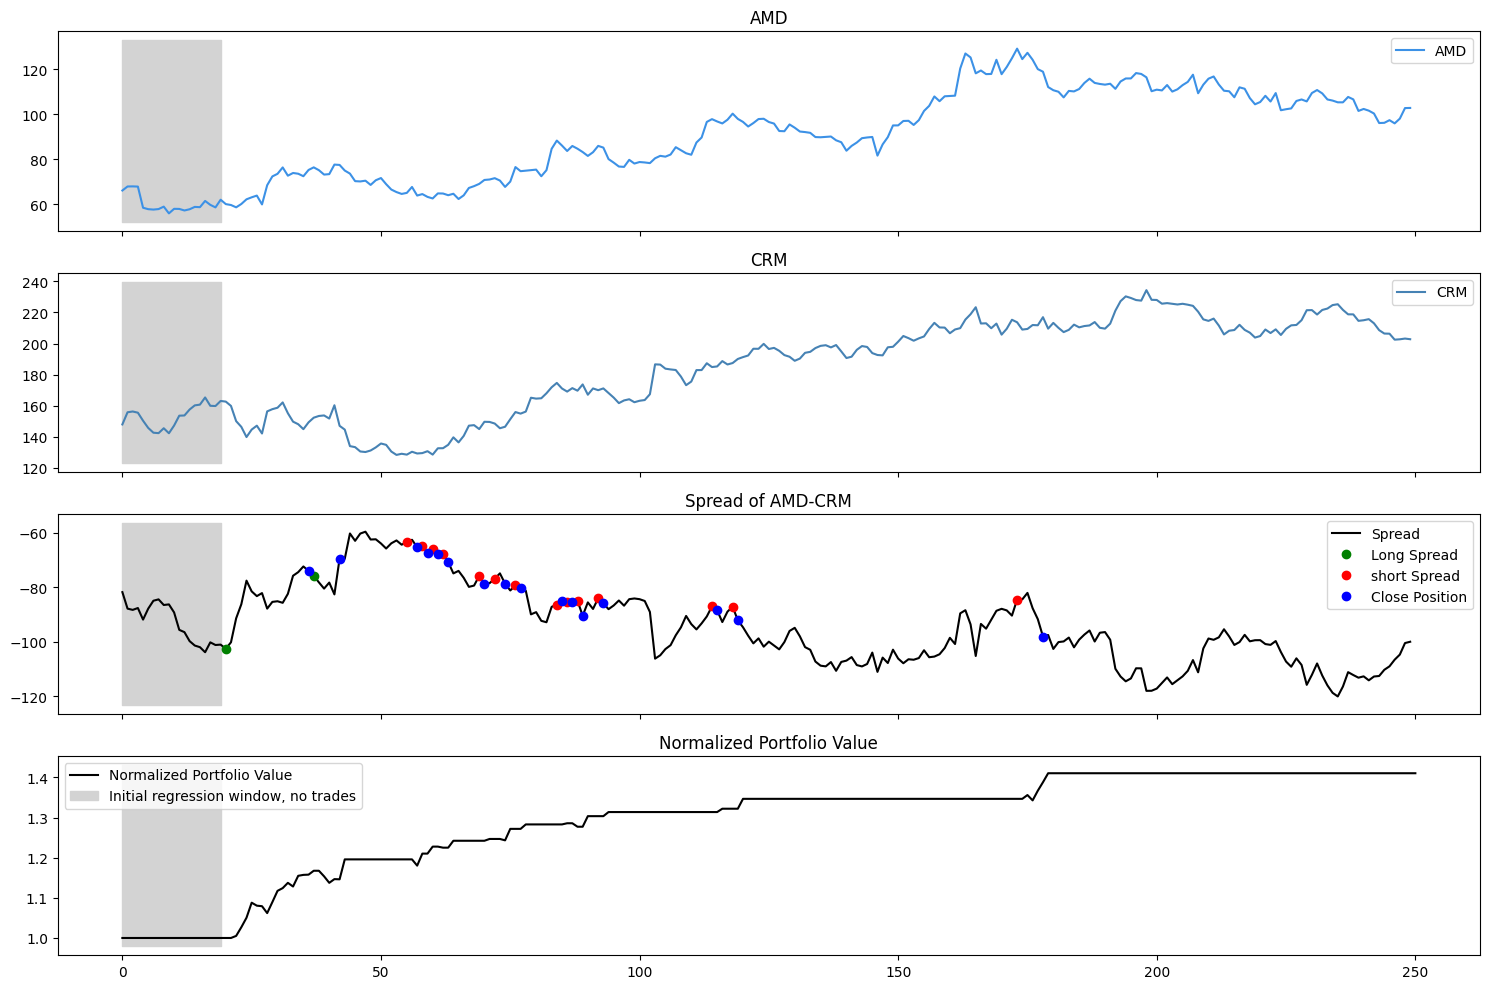

In [8]:
pair_to_plot = 'AMD-CRM'
plot_a_pair(pair_to_plot, tickers, env.pair_indices, price_data_all.cpu().numpy(), reg_rolling_window, port_value_history, action_history)

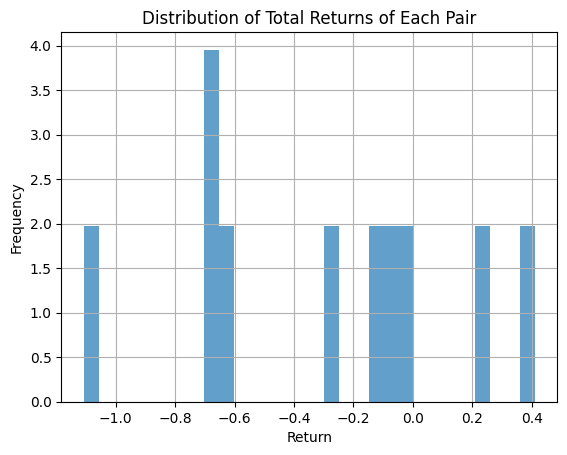

In [9]:
# choices are 'total return of each pair', 'across time steps', and 'all'
plot_return_distribution(port_value_history, choice='total return of each pair', bins=30)

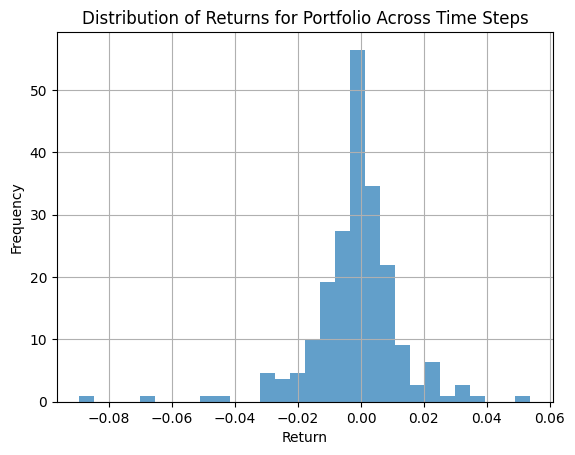

In [10]:
plot_return_distribution(port_value_history, choice='across time steps', bins=30)

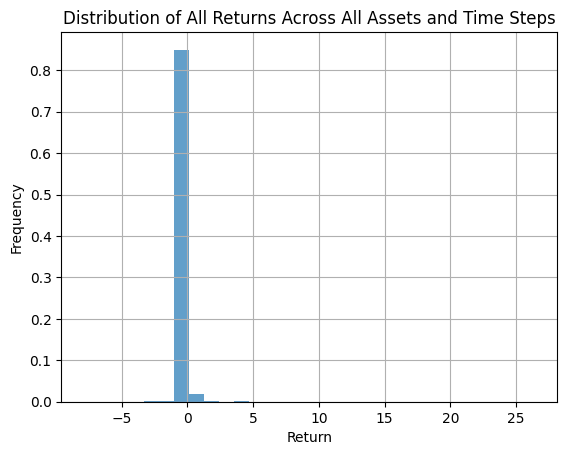

In [11]:
plot_return_distribution(port_value_history, choice='all', bins=30)